In [52]:
import re
import gc
import string
from tqdm import tqdm
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import numpy as np 
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import spacy
from collections import Counter, defaultdict
import en_core_web_sm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [8]:
train_data = pd.read_csv('data/train.csv.zip')
test_data = pd.read_csv('data/test.csv.zip')

In [9]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [10]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [13]:
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [14]:
train_data.shape, test_data.shape

((159571, 8), (153164, 2))

<BarContainer object of 6 artists>

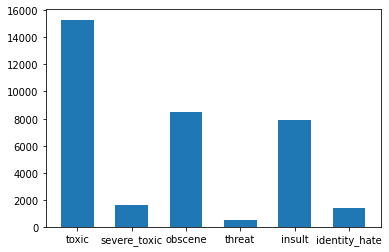

In [15]:
comments = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
comments_count = [train_data.toxic.sum(), train_data.severe_toxic.sum(), 
         train_data.obscene.sum(), train_data.threat.sum(), 
         train_data.insult.sum(), train_data.identity_hate.sum() ]

plt.bar(comments, comments_count, width=0.6)

In [33]:
sum(comments_count)

35098

In [34]:
normal_comments = train_data.loc[ 
    (train_data["severe_toxic"]==0)
   &(train_data["toxic"]==0)
   &(train_data["obscene"]==0)
   &(train_data["threat"]==0)
   &(train_data["insult"]==0)
   &(train_data["identity_hate"]==0)
]

In [35]:
pd.set_option('display.max_colwidth', None)
normal_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,0,0,0,0,0


In [36]:
print("There are {0} comments which are not toxic in the given categories".format(len(normal_comments)))

There are 143346 comments which are not toxic in the given categories


In [37]:
print("Summation of normal comments and toxic comments exceed the total number of comments we have {0}".format(len(normal_comments) + sum(comments_count)))

Summation of normal comments and toxic comments exceed the total number of comments we have 178444


<BarContainer object of 7 artists>

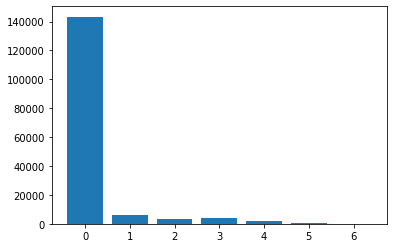

In [38]:
row_sum = train_data.iloc[:, 2:].sum(axis=1)
plt.bar(row_sum.value_counts().index, row_sum.value_counts().values)

In [39]:
df = pd.DataFrame()

In [40]:
#where three category overlaps 
df["unique"] = (row_sum==1)
print("no of comments which lie in unique category/tagged with unique category", df.loc[df["unique"]].shape[0])

df["two_cat"] = (row_sum==2)
print("no of comments which lie in two category/tagged with two category", df.loc[df["two_cat"]].shape[0])

df["three_cat"] = (row_sum==3)
print("no of comments which lie in three category/tagged with three category", df.loc[df["three_cat"]].shape[0])

df["four_cat"] = (row_sum==4)
print("no of comments which lie in four category/tagged with four category", df.loc[df["four_cat"]].shape[0])

df["five_cat"] = (row_sum==5)
print("no of comments which lie in five category/tagged with five category", df.loc[df["five_cat"]].shape[0])

df["six_cat"] = (row_sum==6)
print("no of comments which lie in six category/tagged with six category", df.loc[df["six_cat"]].shape[0])

no of comments which lie in unique category/tagged with unique category 6360
no of comments which lie in two category/tagged with two category 3480
no of comments which lie in three category/tagged with three category 4209
no of comments which lie in four category/tagged with four category 1760
no of comments which lie in five category/tagged with five category 385
no of comments which lie in six category/tagged with six category 31


In [41]:
del df
gc.collect()

15

In [42]:
pd.crosstab(train_data.loc[row_sum==3]["toxic"], 
[
    train_data.loc[row_sum==3]["threat"],
    train_data.loc[row_sum==3]["severe_toxic"],
    train_data.loc[row_sum==3]["identity_hate"],
    train_data.loc[row_sum==3]["obscene"], 
    train_data.loc[row_sum==3]["insult"],   
],
            rownames=["toxic"], 
            colnames=["threat", "severe_toxic", "identity_hate", "obscene", "insult"]
)

threat            0                            1              
severe_toxic      0                1           0             1
identity_hate     0    1           0       1   0         1   0
obscene           1    0   1       0    1  0   0   1     0   0
insult            1    1   0   1   1    0  0   1   0  1  0   0
toxic                                                         
0                 0    0   0  18   0    0  0   0   0  2  0   0
1              3800  134  35   0  14  158  3  16  11  0  7  11

In [43]:
threat_comments = train_data.loc[ (train_data["threat"]==1) ]

In [44]:
threat_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undoing my edits or die!,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms,1,0,1,1,1,1
600,0199d6af27b715f3,"I'm also a sock puppet of this account...SUPRISE!!\n-sincerely,\n The man that will track you down from the Internet and kill you",1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when you die. I want to dance on your grave.",1,0,1,1,1,0
1017,02c6e41e4b317ac3,"WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
157718,e26b106943e02cbf,"bitch \nyou are a fucking hore. you suck dick you big ass hole. you are gay you faggot ass bitch. you can go to hell you bitch ass motherfucker, suck a big dick asshole. i'm fuckin your mom ho. she can't get off my dick. your daddy probably raped you in the ass everyday when you were young you stupid ass motherfuck.",1,0,1,1,1,1
158717,f264b7fb9a4b4f53,stupid head \n\nYOur dumb and you are stupid die die die go suck a butt,1,0,1,1,1,0
158856,f4dca9e513e0366f,"Hey \n\nhey faggot, are you dead yet? or are you watching your mom getting raped by filthy pigs? which one is it? I'm coming to rape your mom and shoot your entire family. You have 1 week to live, you motherfucker.",1,1,1,1,1,0
159029,f780e4f42aa5a344,Death to Musulmans!,1,0,0,1,0,1


In [45]:
pd.set_option('display.max_colwidth', None)
pd.crosstab(threat_comments["threat"]==1, 
[
    threat_comments["toxic"]==1,
    threat_comments["severe_toxic"]==1,
    threat_comments["identity_hate"]==1,
    threat_comments["obscene"]==1, 
    threat_comments["insult"]==1,   
],
            rownames=["threat"], 
            colnames=["toxic", "severe_toxic", "identity_hate", "obscene", "insult"]
)

toxic         False                   True                                 \
severe_toxic  False                   False                                 
identity_hate False                   False                   True          
obscene       False       True        False       True        False         
insult        False True  False True  False True  False True  False True    
threat                                                                      
True             22     3     2     2   113    16    11   131     7     3   

toxic                                                    
severe_toxic        True                                 
identity_hate       False                   True         
obscene       True  False       True        False True   
insult        True  False True  False True  False True   
threat                                                   
True             56    11     1     4    64     1    31

In [46]:
del threat_comments
gc.collect()

15

In [47]:
wc_stopwords=set(STOPWORDS)

In [48]:
normal_comments["comment_text"].values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

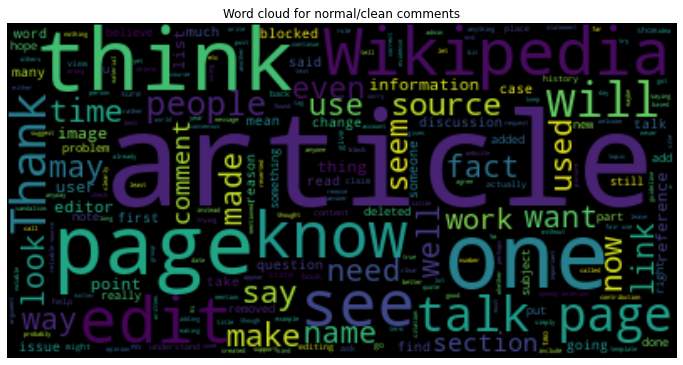

In [49]:

wc_normal = WordCloud(max_words=4000, min_font_size=4,        
                      stopwords=wc_stopwords, background_color="black",  random_state=1).generate(" ".join(normal_comments["comment_text"].values))
plt.figure(figsize=(12, 15))
plt.title("Word cloud for normal/clean comments")
plt.axis("off")
plt.imshow(wc_normal, interpolation = 'bilinear')

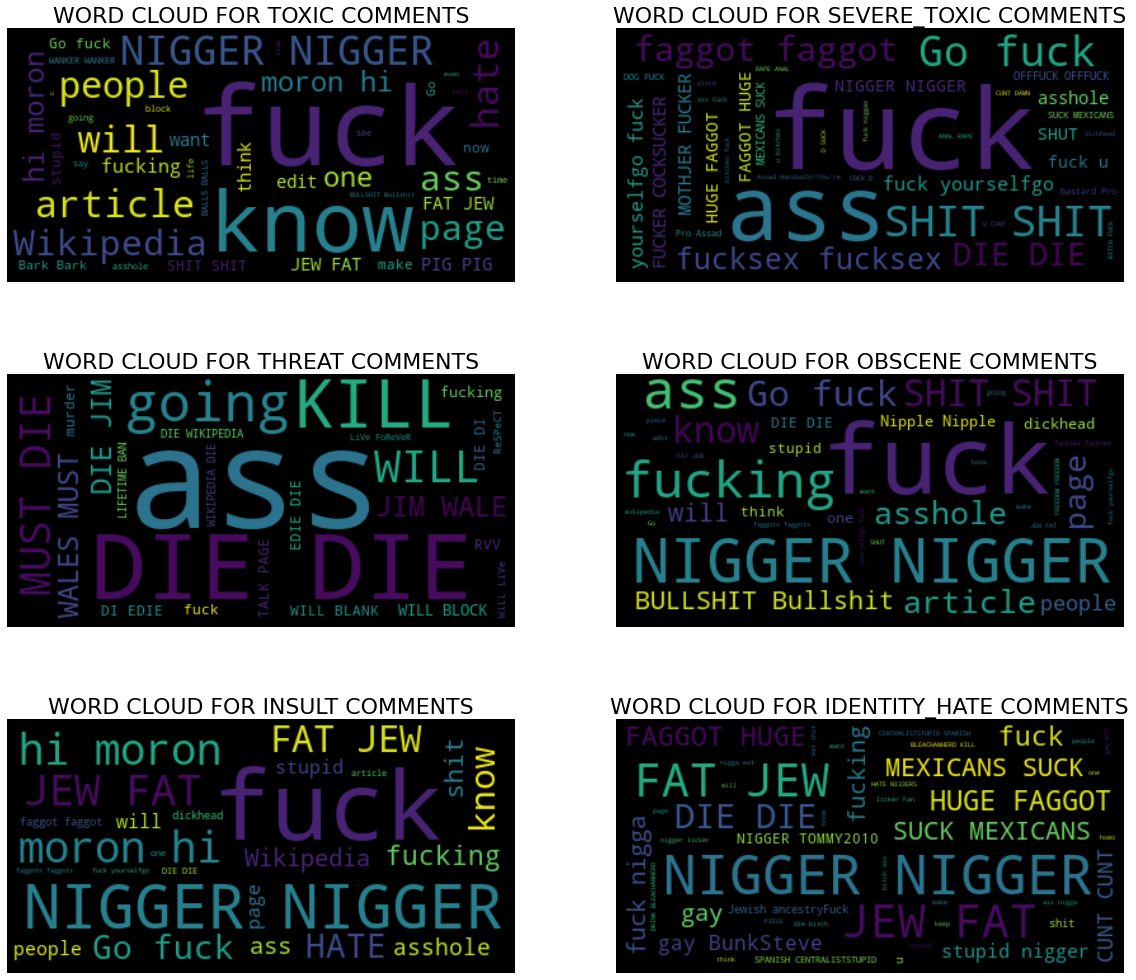

In [54]:
plt.figure(figsize=(20, 18))

for i, category in enumerate(["toxic", "severe_toxic", "threat", "obscene", "insult", "identity_hate"]):
    plt.subplot(3,2,i+1)
    wc_normal = WordCloud(max_words=4000, min_font_size=5,
          
                          stopwords=wc_stopwords, background_color="black", 
                          margin=10, random_state=1).generate(" ".join(train_data[train_data[category]==1].comment_text.values))
    plt.title("Word cloud for {0} comments".format(category).upper(), fontsize=22)
    plt.axis("off")
    plt.imshow(wc_normal, interpolation = 'bilinear')

In [59]:
nlp = en_core_web_sm.load()
print(nlp.get_pipe("ner").labels)
print(nlp.get_pipe("ner").cfg)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')
{'moves': None, 'update_with_oracle_cut_size': 100, 'multitasks': [], 'min_action_freq': 1, 'learn_tokens': False, 'beam_width': 1, 'beam_density': 0.0, 'beam_update_prob': 0.0}


In [61]:
%%time

#
#Named entities for  comments
#list which are in ORG,
#NORP Nationalities or religious or political group
#

texts = train_data["comment_text"].values
orgs = []

for doc in nlp.pipe(texts, disable=["tagger", "parser", "lemmatizer", "ner"]):
    orgs.extend([ent.text for ent in doc.ents if not ent.text.isspace() and ent.label_=="ORG"])
#now list out the most frequent ORG used in the data
Counter(orgs).most_common(50)

CPU times: user 9min 41s, sys: 2min 31s, total: 12min 13s
Wall time: 13min 26s


[]

In [62]:
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

In [63]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [72]:
REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
REPLACE_DIGITS = re.compile(r'\d+')
REPLACE_PUNCTUATION = re.compile(r'!\"#+$%&\)*,-./:;<=>?@[\\]^_`{|}~\t\(\\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—')     #[,!@\'\"?\.$%_&#*+-:;]")       #[!\"#$%&\'()*+,-\./:;<=>?@[\\]^_`{|}~]")
LEAKY_FEATURE = re.compile(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}") 

STOPWORDS = set(stopwords.words('english'))

sentences = [] #for Word2Vec model

def clean_text(text):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    
    text = re.sub(r'&amp;', '&', text)
    
    text = REPLACE_URLS.sub('', text)
    #text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    text = REPLACE_DIGITS.sub('', text)
    text = REPLACE_PUNCTUATION.sub(' ' , text)
    text = LEAKY_FEATURE.sub('', text)
    
    text = [APPO[word] if word in APPO else word for word in text.split()]
    
    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in text if word not in STOPWORDS)
    
    #sentences.append(text.split())
    return text

In [71]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohochen/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [73]:
%%time
train_data["comment"] = train_data["comment_text"].apply(clean_text)

CPU times: user 24min 50s, sys: 4min 27s, total: 29min 17s
Wall time: 45min 24s


In [74]:
%%time
test_data["comment"] = test_data["comment_text"].apply(clean_text)

CPU times: user 21min 56s, sys: 3min 48s, total: 25min 45s
Wall time: 37min 54s


In [75]:
df_count = train_data.loc[:, ["id", "comment_text", "comment"]]
df_count["word_count"] = df_count["comment_text"].apply(lambda x: len(str(x).split()))
df_count["sent_count"] = df_count["comment_text"].apply(lambda x: len(re.findall("\n", str(x))) +1)
df_count["unique_words"] = df_count["comment_text"].apply(lambda x : len(set(str(x).split())))

In [76]:
#count in comments after data cleaning
df_count["word_count_clean"] = df_count["comment"].apply(lambda x: len(str(x).split()))
#df_count["sent_count_clean"] = df_count["comment"].apply(lambda x: len(re.findall("\n", str(x))) +1)
df_count["unique_words_clean"] = df_count["comment"].apply(lambda x : len(set(str(x).split())))

In [77]:
print( "min and max word count in comment before cleaning >> ", min(df_count["word_count"]), max(df_count["word_count"]) )
print( "min and max unique words in comment before cleaning >> ", min(df_count["unique_words"]), max(df_count["unique_words"]) )
print( "min and max  word count in comment after cleaning >> ", min(df_count["word_count_clean"]), max(df_count["word_count_clean"]) )
print( "min and max  unique word in comment after cleaning >> ", min(df_count["unique_words_clean"]), max(df_count["unique_words_clean"]) )

min and max word count in comment before cleaning >>  1 1411
min and max unique words in comment before cleaning >>  1 816
min and max  word count in comment after cleaning >>  0 1250
min and max  unique word in comment after cleaning >>  0 552


In [78]:
toxic_index = train_data[train_data["toxic"]==1]["id"]
severe_toxic_index = train_data[train_data["severe_toxic"]==1]["id"]
threat_index = train_data[train_data["threat"]==1]["id"]
obscene_index = train_data[train_data["obscene"]==1]["id"]
insult_index = train_data[train_data["insult"]==1]["id"]
identity_hate_index = train_data[train_data["identity_hate"]==1]["id"]

In [79]:
category_list = ["toxic", "severe_toxic", "threat", "obscene", "insult", "identity_hate"]
avg_count = []
avg_unique_count = []
unique_to_all = []

for i, category in enumerate([toxic_index, severe_toxic_index, threat_index, obscene_index, insult_index, identity_hate_index]):
    avg_count.append(df_count[df_count.id.isin(category)]["word_count"].mean())
    avg_unique_count.append(df_count[df_count.id.isin(category)]["unique_words"].mean())
    
avg_count.append(df_count[df_count.id.isin(normal_comments.id)]["word_count"].mean())
avg_unique_count.append(df_count[df_count.id.isin(normal_comments.id)]["unique_words"].mean())


for i, category in enumerate([toxic_index, severe_toxic_index, threat_index, obscene_index, insult_index, identity_hate_index]):
    ratio = df_count[df_count.id.isin(category)]["unique_words"]/df_count[df_count.id.isin(category)]["word_count"] 
    unique_to_all.append(ratio.mean()*100)
    
unique_to_all.append( (df_count[df_count.id.isin(normal_comments.id)]["unique_words"]/df_count[df_count.id.isin(normal_comments.id)]["word_count"] ).mean()*100)

category_list.append("normal")

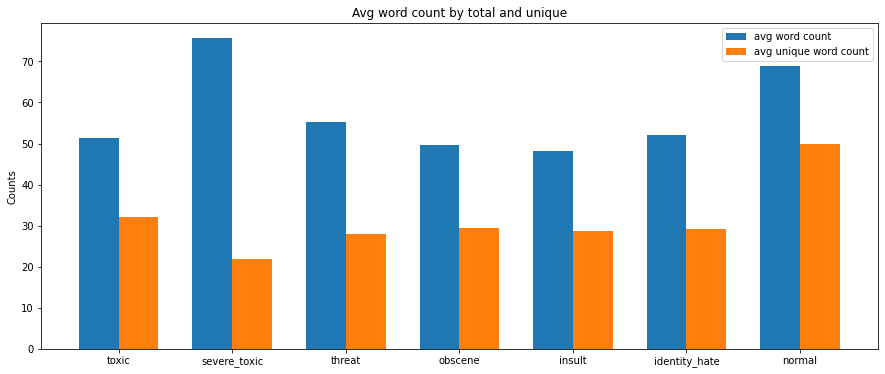

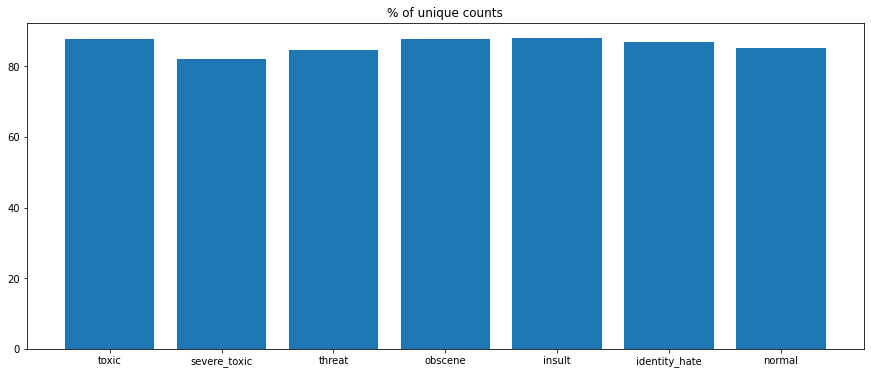

In [80]:
x = np.arange(len(category_list))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
count_bar = ax.bar(x - width/2, avg_count, width, label='avg word count')
unique_count_bar = ax.bar(x + width/2, avg_unique_count, width, label='avg unique word count')
ax.set_ylabel('Counts')
ax.set_title("Avg word count by total and unique")
ax.set_xticks(x)
ax.set_xticklabels(category_list)
ax.legend()

plt.figure(figsize=(15,6))
plt.bar(category_list, unique_to_all, width=0.8)
plt.title("% of unique counts")
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


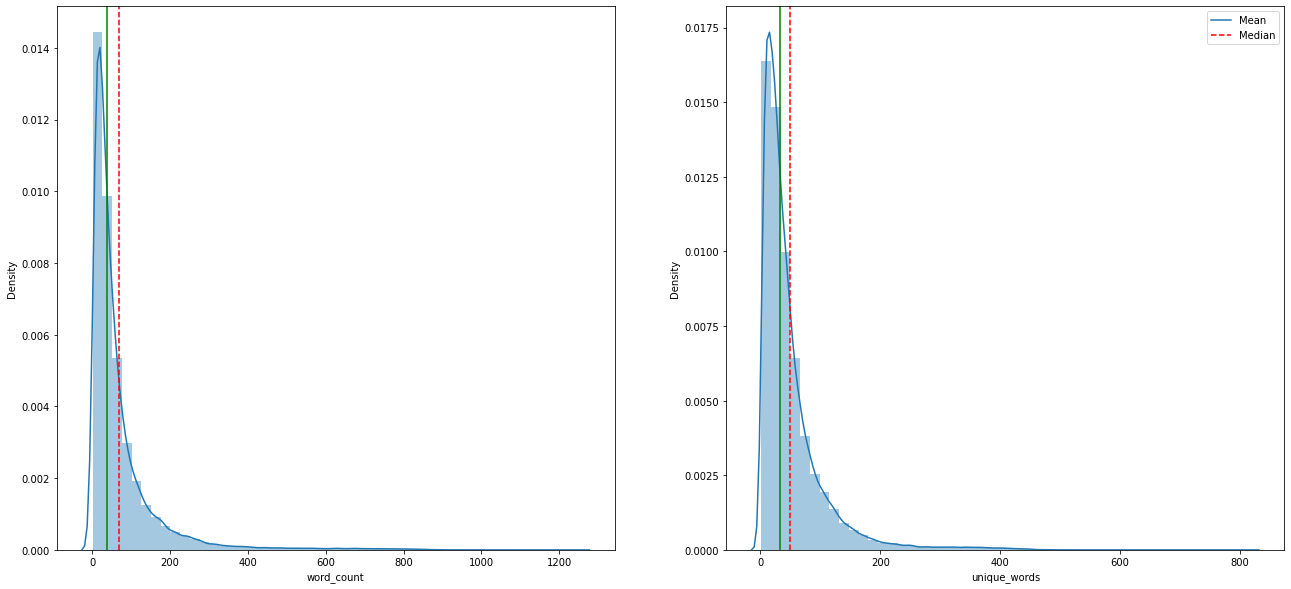

In [81]:
import seaborn as sns
f, (ax_wc, ax_uwc) = plt.subplots(1,2, figsize=(22,10))

mean_wc = df_count[df_count.id.isin(normal_comments["id"])]["word_count"].mean()
median_wc = df_count[df_count.id.isin(normal_comments["id"])]["word_count"].median()
mode_wc = df_count[df_count.id.isin(normal_comments["id"])]["word_count"].mode()

sns.distplot(df_count[df_count.id.isin(normal_comments["id"])]["word_count"], ax=ax_wc)
ax_wc.axvline(mean_wc, color='r', linestyle='--')
ax_wc.axvline(median_wc, color='g', linestyle='-')

mean_uwc = df_count[df_count.id.isin(normal_comments["id"])]["unique_words"].mean()
median_uwc = df_count[df_count.id.isin(normal_comments["id"])]["unique_words"].median()
mode_uwc = df_count[df_count.id.isin(normal_comments["id"])]["unique_words"].mode()

sns.distplot(df_count[df_count.id.isin(normal_comments["id"])]["unique_words"], ax=ax_uwc)
ax_uwc.axvline(mean_uwc, color='r', linestyle='--')
ax_uwc.axvline(median_uwc, color='g', linestyle='-')

plt.legend({'Mean':mean_wc,'Median':median_wc})
plt.show()

In [82]:
del df_count
del toxic_index
del severe_toxic_index
del threat_index
del obscene_index
del insult_index
del identity_hate_index
gc.collect()

2951

### N Gram


In [83]:
def find_ngrams(input_list, n):
   return zip(*[input_list[i:] for i in range(n)])

In [84]:
train_tags = train_data.loc[:, ["id", "toxic", "severe_toxic", "threat", "obscene", "insult", "identity_hate"]]

In [85]:
train_data.loc[:, ["id", "toxic", "severe_toxic", "threat", "obscene", "insult", "identity_hate"]].columns[1:]

Index(['toxic', 'severe_toxic', 'threat', 'obscene', 'insult',
       'identity_hate'],
      dtype='object')

In [86]:
train_data.iloc[12235]["comment_text"]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [87]:
train_data.iloc[12235]["comment"]

'" note read above, follow links, reader see cite correctly link add subject. vidkun add anotations make read oposite, link show ""official"" line take ugle. trap user so-called rr, peddle pov. strangly, ""masons"" quiet, leave ‘‘me’’ defend factual truth own. ""thanks"" brethren. sit block given... "'

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_bi = TfidfVectorizer(min_df=100,  max_features=80000, 
                                   strip_accents='unicode', analyzer='word',ngram_range=(2,2),
                                   use_idf=1,smooth_idf=1,sublinear_tf=1,
                                   stop_words = 'english')

tfidf_vectorizer_bi.fit(pd.concat([train_data["comment"], test_data["comment"] ]))
features = np.array(tfidf_vectorizer_bi.get_feature_names())

train_bigrams =  tfidf_vectorizer_bi.transform(train_data["comment"])
test_bigrams = tfidf_vectorizer_bi.transform(test_data["comment"])

In [89]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns[1:]
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = comments
        dfs.append(feats_df)
    ids = train_tags.index[train_tags.id.isin(normal_comments.id)]
    feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
    feats_df.label = "clean"
    dfs.append(feats_df)
    return dfs

In [90]:
%%time
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

<ipython-input-89-06ada1fd8188>:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  feats_df.label = comments
<ipython-input-89-06ada1fd8188>:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  feats_df.label = comments
<ipython-input-89-06ada1fd8188>:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  feats_df.label = comments
<ipython-input-89-06ada1fd8188>:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  feats_df.label = comments
<ipython-input-89-06ada1fd8188>:33: UserWarning: Pandas doesn't allow columns to be created 

CPU times: user 4.37 s, sys: 6.5 s, total: 10.9 s
Wall time: 16.2 s


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-pack

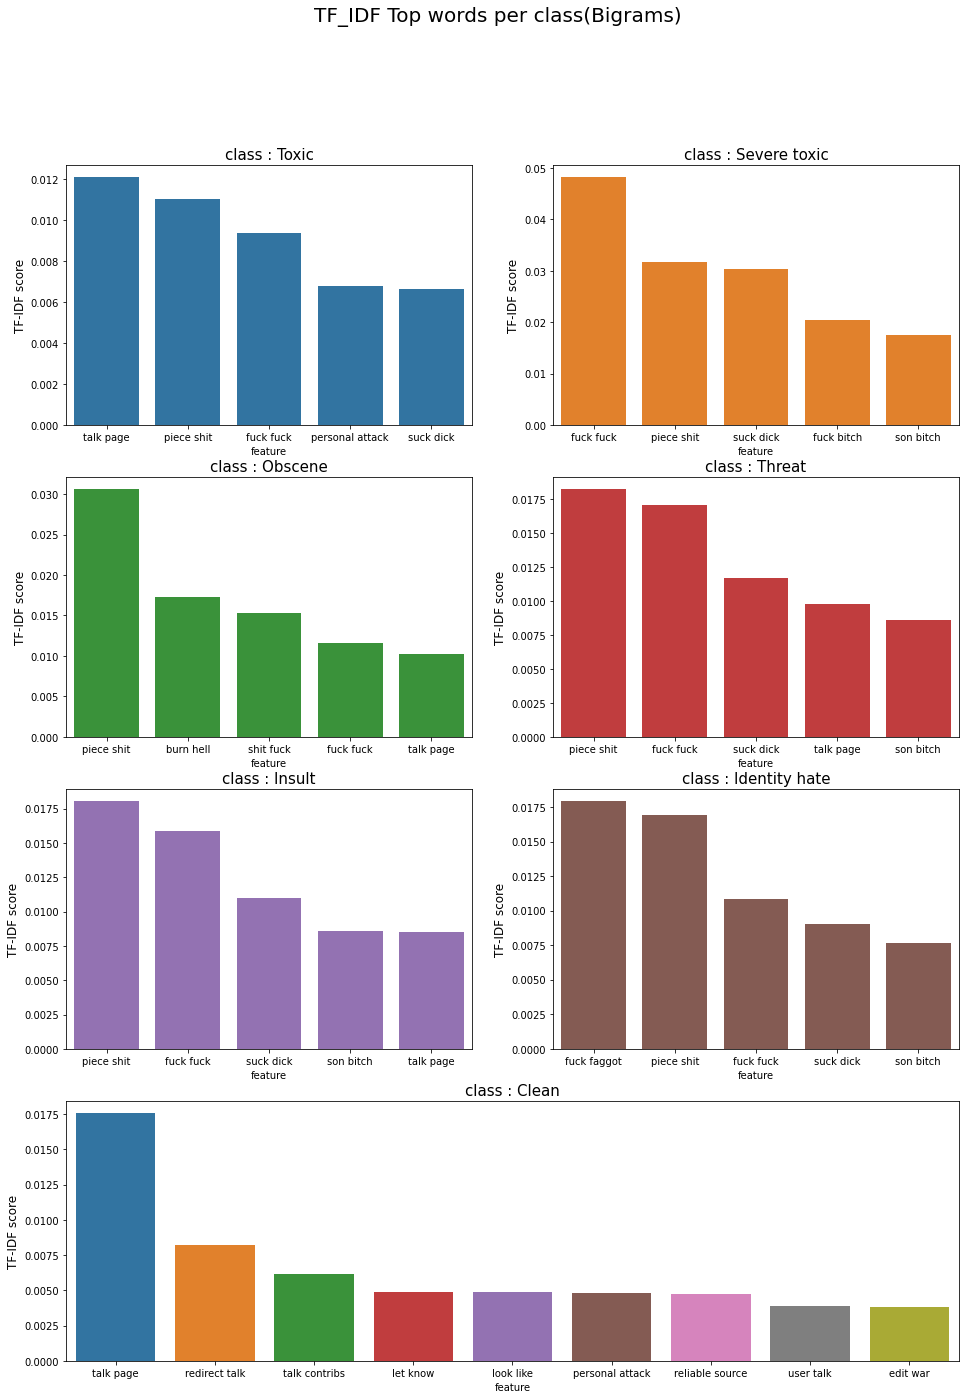

In [91]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
#plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [92]:
del normal_comments
del tfidf_vectorizer_bi
del train_bigrams
del test_bigrams
gc.collect()

22491

### LSTM

In [106]:
train_data_lstm_11col = pd.read_csv("data/lstm/jigsaw-toxic-comment-train-processed-seqlen128.csv.zip")
train_data_lstm = pd.read_csv("data/lstm/jigsaw-toxic-comment-train.csv.zip")


In [107]:
train_data_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


In [108]:
train_data_lstm.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [110]:
max_len = np.max(train_data_lstm["comment_text"].apply(lambda x: len(x)))
max_len

5000

In [145]:
REMOVE_CHARS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
max_features = 100000


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, SpatialDropout1D, Embedding, add, concatenate, Concatenate, Input
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPool1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [136]:

tokenizer = Tokenizer(filters=REMOVE_CHARS, num_words=100000)

tokenizer.fit_on_texts(list(train_data_lstm["comment_text"].astype(str)))

vocab_size = len(tokenizer.word_index) + 1
X_tokenized = tokenizer.texts_to_sequences(train_data_lstm["comment_text"].astype(str))
X_tokenized = pad_sequences(X_tokenized, maxlen=5000, padding='post')


In [125]:
embeddings_index = {}
glovefile = open('data/lstm/glove.42B.300d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

1917494it [03:42, 8628.44it/s] 

Found 1917494 word vectors.


In [126]:
num_words = min(max_features, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, index in tqdm(tokenizer.word_index.items()):
    try:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    except IndexError:
        pass

100%|██████████| 272099/272099 [00:03<00:00, 77758.35it/s] 


In [129]:
del embeddings_index
gc.collect()

164

In [127]:
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

In [128]:
y_train = train_data[["toxic", "severe_toxic","threat","obscene", "insult", "identity_hate"]].values

In [130]:
embedding_matrix.shape

(100000, 300)

In [131]:
X_tokenized.shape, y_train.shape

((223549, 5000), (223549, 6))

In [146]:
def build_model(embedding_matrix):
    inp = Input(shape=(max_len,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [148]:
model_lstm = build_model(embedding_matrix)
# model_lstm.summary()

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
history_lstm = model_lstm.fit(
    X_tokenized, 
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=512,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [150]:
def build_model(embedding_matrix):
    words = Input(shape=(5000,))
    
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x1 = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
    x2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x1)
    
    #avg_pool = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x1)
    max_pool2 = GlobalMaxPooling1D()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    
#     hidden = add([conc, Dense(DENSE_HIDDEN_UNITS, activation='relu')(conc)])
#     hidden = Dropout(0.2)(hidden)
#     hidden = add([conc, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    
    result = Dense(6, activation='softmax')(conc)
    
    model = Model(inputs=words, outputs=result)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [151]:
model_lstm = build_model(embedding_matrix)

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_4/forward_cu_dnnlstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [171]:
# Pausing here due to the following ERROR: Python3.9 not compatible with _keras_tensor_symbolic_call

In [ ]:
# ---------------------------------------------------------------------------
# NotImplementedError                       Traceback (most recent call last)
# <ipython-input-151-8ffd800759cf> in <module>
# ----> 1 model_lstm = build_model(embedding_matrix)

# ...
# ...
# ...

# /usr/local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py in __array__(self)
#     865 
#     866   def __array__(self):
# --> 867     raise NotImplementedError(
#     868         "Cannot convert a symbolic Tensor ({}) to a numpy array."
#     869         " This error may indicate that you're trying to pass a Tensor to"

# NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_4/forward_cu_dnnlstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported